# Sentiment Analysis using Python (Part I - Machine learning model comparison)

## Introduction

The sudden ejection of activity in the field of opinion mining and sentiment analysis, which manages the computational treatement of opinion, sentiment and subjectivity in text, has consequently happened at least partially as an immediate reaction to the surge of enthusiasm for new frameworks that deal specifically with sentiments as a top of the lime question.
This task involves classifying opinions in text into categories like "positive" or "negative", it is also called opinion mining or voice of the customer.
Sentiment analysis is used for several applications, particularly in business intelligence, a few cases of utilizations for sentiment analysis include:
- Analysing social media content.
- Evaluating Movies/Product reviews..

In this tutorial, we will focus on the last application. By the end of it, you will:
- Understand how sentiment analysis works.
- clean and pre-process the dataset.
- Leverage some machine learning/deep learning models to analyse the sentiment of texts.
- Visualize the results...

## Dataset

For this tutorial, we are going to use python and further libraries to analyse the sentiment Imdb movie reviews, 
we are going to use a pre-constructed annotated dataset that contains 25 000 rows. the dataset can be downloaded from this link <a href="https://drive.google.com/file/d/1X5ygSwrUctx0Uticp3ASYobQL51FNyC8/view?usp=sharing"> link </a>. 


OK, Let's take a look at our data by defining a function that loads the training data and extracts the two columns we need: Sentiment and Text.


In [167]:
import pandas as pd

In [168]:
def ingest_train():
    data = pd.read_csv('~/Datasets/newdataset.csv')
    data = data[data.Sentiment.isnull() == False]
    data['Sentiment'] = data['Sentiment'].map(int)
    data = data[data['SentimentText'].isnull() == False]
    data['SentimentText'] = data['SentimentText'].astype('str')
    data.reset_index(inplace=True)
    data.drop('index', axis=1, inplace=True)
    return data


In [169]:
train = ingest_train()

In [170]:
from sklearn.utils import shuffle
train = shuffle(train)
train.head()

,Sentiment,SentimentText
23096,4,"@courtneyjoy Hopefully, my future phone. But ..."
30500,0,"ugh my head, too many margaritas for a monday ..."
48145,0,are you kidding me?! fucking a! @blackestrayne...
29677,0,I plan on watching the Fast and the Furious la...
7243,4,Lmao histericly even @ the voicemails I woke u...


## Data Preparation

Now, It looks like it’s time for some cleaning!

Let's first define data cleaning function, an then apply it to the whole dataset. This function remove URL, remove HTML tags, handle negation words which are splited into two parts, convert the words to lower cases, remove all non-letter characters. These elements are very common and they do not provide enough semantic information for the task. 


In [171]:
import re

pat_1 = r"(?:\@|https?\://)\S+"
pat_2 = r'#\w+ ?'
combined_pat = r'|'.join((pat_1, pat_2))
www_pat = r'www.[^ ]+'
html_tag = r'<[^>]+>'
negations_ = {"isn't":"is not", "can't":"can not","couldn't":"could not", "hasn't":"has not",
                "hadn't":"had not","won't":"will not",
                "wouldn't":"would not","aren't":"are not",
                "haven't":"have not", "doesn't":"does not","didn't":"did not",
                 "don't":"do not","shouldn't":"should not","wasn't":"was not", "weren't":"were not",
                "mightn't":"might not",
                "mustn't":"must not"}
negation_pattern = re.compile(r'\b(' + '|'.join(negations_.keys()) + r')\b')

In [172]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

In [173]:
def data_cleaner(text):
    try:
        stripped = re.sub(combined_pat, '', text)
        stripped = re.sub(www_pat, '', stripped)
        cleantags = re.sub(html_tag, '', stripped)
        lower_case = cleantags.lower()
        neg_handled = negation_pattern.sub(lambda x: negations_[x.group()], lower_case)
        letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
        tokens = tokenizer.tokenize(letters_only)
        return (" ".join(tokens)).strip()
    except:
        return 'NC'

The results of this should give us a cleaned datasets and remove lines with 'NC'.

Next, let's define a handy function to monitor DataFrame creations, then look at our cleaned data.

In [174]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

def post_process(data, n=1000000):
    data = data.head(n)
    data['SentimentText'] = data['SentimentText'].progress_map(data_cleaner)  
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    data.dropna()
    return data

In [175]:
train = post_process(train)
train["Sentiment"] = train["Sentiment"].replace(4,1)
train.head()


progress-bar: 100%|██████████| 50000/50000 [00:01<00:00, 29503.36it/s]


,Sentiment,SentimentText
0,1,hopefully my future phone but i doubt it it s ...
1,0,ugh my head too many margaritas for a monday c...
2,0,are you kidding me fucking a gimme a bit bb my...
3,0,i plan on watching the fast and the furious la...
4,1,lmao histericly even the voicemails i woke up ...


After that, we can save the cleaned data as csv.

In [176]:
clean_data = pd.DataFrame(train,columns=['SentimentText'])
clean_data['Sentiment'] = train.Sentiment

clean_data.to_csv('~/clean_data.csv',encoding='utf-8')

csv = '~/clean_data.csv'
train = pd.read_csv(csv,index_col=0)

train["Sentiment"].replace(4, 1)
    
train.head()

,SentimentText,Sentiment
0,hopefully my future phone but i doubt it it s ...,1
1,ugh my head too many margaritas for a monday c...,0
2,are you kidding me fucking a gimme a bit bb my...,0
3,i plan on watching the fast and the furious la...,0
4,lmao histericly even the voicemails i woke up ...,1


## Data visualization


Before proceeding to the classification step, let's do some visualization of our textual data. the words cloud is a best choice for this matter, it is a visual representation of text data. It displays a list of words, the importance of each beeing shown with font size or color. This format is useful for quickly perceiving the most prominent terms.

For this data viz, we use the python library wordcloud.

Let's beging with the word cloud of negative terms.

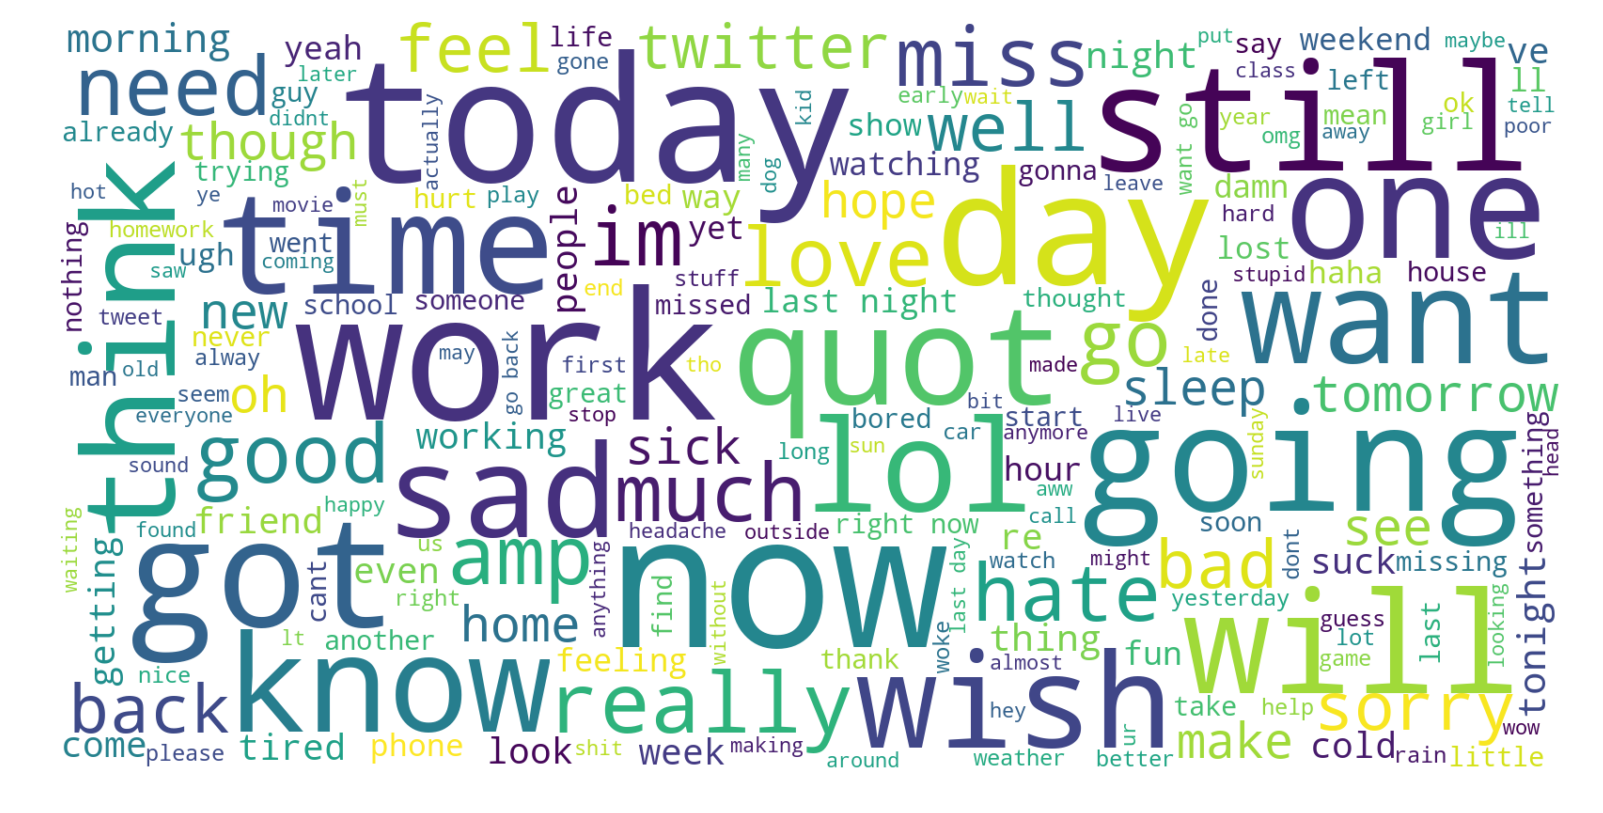

In [177]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from wordcloud import WordCloud, STOPWORDS


neg_tweets = train[train.Sentiment == 0]
neg_string = []
for t in neg_tweets.SentimentText:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color='white').generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The world cloud for the positive terms.

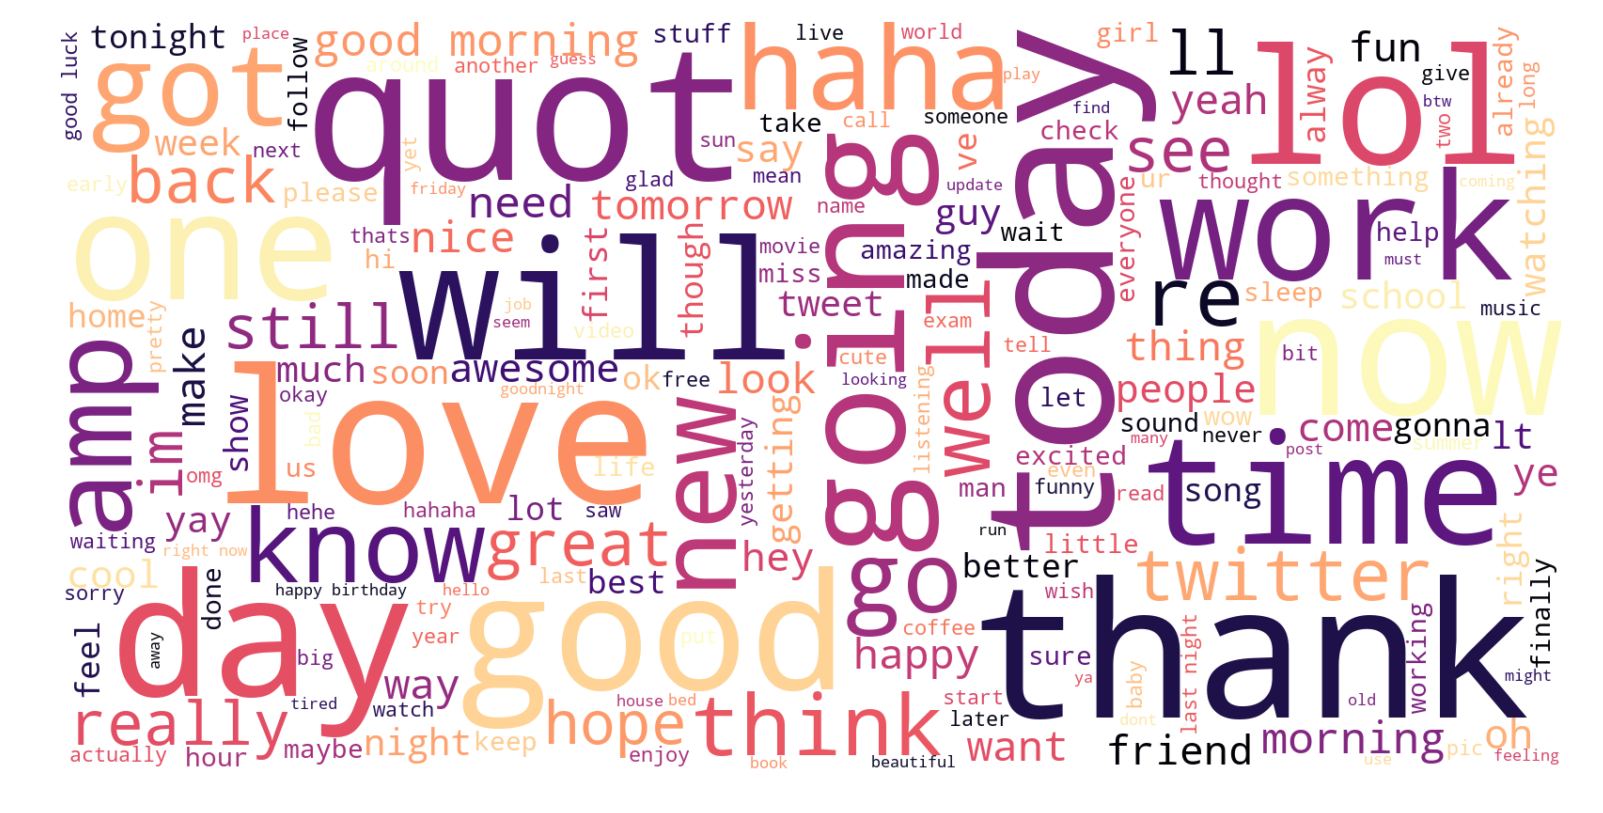

In [178]:
pos_tweets = train[train.Sentiment == 1]
pos_string = []
for t in pos_tweets.SentimentText:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma', background_color='white').generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

We can see some netural words in big size, “film”,”movie”,"character", but words like “good”, “love”, “great” are relevant for positive words and "bad', "little" for negative words.

## Building the models

Before proceeding to the training phases, let's split our data into training and validation set.

In [179]:
#Spliting The Data

from sklearn.cross_validation import train_test_split
SEED = 2000

x_train, x_validation, y_train, y_validation = train_test_split(train.SentimentText.head(25000), train.Sentiment.head(25000), test_size=.2, random_state=SEED)

## Features Extraction


In this part, we will use afeature extraction technique called Tfidf vectorizer of 100,000 features including up to trigram. This technique is a way to convert textual data to numeric form. 

The below model_comparator function, we will use a custom function acc_summary, which reports validation accuracy, and the time it took to train and evaluate.

In [189]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
import numpy as np
from time import time

def acc_summary(pipeline, x_train, y_train, x_test, y_test):
   
    x_train = x_train.fillna(' ')
    x_test = x_test.fillna(' ')
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
   
    #Compute the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    #Compute the precision and recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    #Compute the average precision
    average_precision = average_precision_score(y_test, y_pred)
  
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    print('Average precision-recall score: {0:.2f}%'.format(average_precision*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    print ("-"*80)
    return accuracy, precision, recall, average_precision, fpr, tpr

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, Perceptron, LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]

zipped_clf = zip(names,classifiers)

vec = TfidfVectorizer()
def classifier_comparator(vectorizer=vec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_acc,prec, rec, avg, fp, tp))
    return result

result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Average precision-recall score: 70.05%
accuracy score: 76.14%
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Average precision-recall score: 70.18%
accuracy score: 76.34%
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1

A summary of the results for comparison is given below.

| Classifier | Accuracy | Train and test time |
| --- | --- | --- |
| Logistic regression | 89.36% | 48.01s |
| Linear SVC | 90.48% | 130.99s |
| LinearSVC with L1-based feature selection | 89.68% | 68.35s |
| Multinomial NB | 87.86% | 48.57s |
| Bernoulli NB | 87.82% | 66.07s |
| Ridge Classifier | 90.54% | 46.96s |
| AdaBoost | 80.72% | 66.22s |
| Perceptron | 89.02% | 44.78s |
| Passive-Aggresive | 90.12% | 45.59s |
| Nearest Centroid | 81.50% | 52.60s |


Thus, It looks like Ridge Classifier and Linear SVC are the best performing classifier in our case.

That's it for this part, we will try in the next post to implement Word2vec and Doc2Vec to see if there is any improvement in the performance.

Thank you for reading :)

In [190]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import numpy as np

acc=[]
names = []
avg_ = []
fp_ = []
tp_ = []

for name, accuracy, prec, rec, avg, fp, tp in result:
    acc.append(accuracy*100)
    names.append(name)
    avg_.append(avg*100)
    fp_.append(fp)
    tp_.append(tp)
    
trace1 = go.Bar(
    x=names,
    y=acc,
    name='Accuracy percentage (%)'
)
trace3 = go.Bar(
    x=names,
    y=avg_,
    name='Average precision (%)'
)

data = [trace1, trace3]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

In [191]:
data = []
for i in range(0, len(names)):
    trace = go.Scatter(x=fp_[i], y=tp_[i],
                        mode='lines', 
                        name='ROC curve {}'
                               ''.format(names[i]))
    data.append(trace)
    
layout = go.Layout(title='Receiver operating characteristic ',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=data, layout=layout)
    
py.iplot(fig)

In [200]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

_fp_ = []
_tp_ = []
names = ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']
eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], names):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=100000,ngram_range=(1, 3))),
            ('classifier', clf)
        ])
    print "Validation result for {}".format(label)
    print clf
    clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
    _fp_.append(fp)
    _tp_.append(tp)

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Average precision-recall score: 70.05%
accuracy score: 76.14%
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Average precision-recall score: 70.18%
accuracy score: 76.34%
--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Average precision-recall score: 70.64%
accuracy score: 76.08%
-

/home/oumaima/anaconda2/envs/nlp/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [201]:
data = []
for i in range(0, len(_fp_)):
    trace = go.Scatter(x=_fp_[i], y=_tp_[i],
                        mode='lines', 
                        name='ROC curve {}'
                               ''.format(names[i]))
    data.append(trace)
    
layout = go.Layout(title='Receiver operating characteristic ',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=data, layout=layout)
    
py.iplot(fig)